Checking For GPU Support

In [72]:
# Importing necessary libraries for the project
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Checking the number of available GPUs
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1


Importing Libraries

In [73]:
# Importing other essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras import models, layers, optimizers, callbacks
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from keras.regularizers import l2

Loading and Preprocessing Data

In [74]:
# Loading the dataset
data = pd.read_csv("data_csv/fer.csv")

# Displaying the first few rows of the dataset
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [75]:
# Checking the shape and columns of the dataset
print(data.shape)
print(data.columns)

(35887, 3)
Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [76]:
# Counting the different usage types in the dataset
data["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [77]:
# Splitting the dataset into training, public test, and private test sets
training = data.loc[data["Usage"] == "Training"]
public_test = data.loc[data["Usage"] == "PublicTest"]
private_test = data.loc[data["Usage"] == "PrivateTest"]

# Displaying the shapes of the splits
print(training.shape)
print(public_test.shape)
print(private_test.shape)

(28709, 3)
(3589, 3)
(3589, 3)


In [78]:
# Preparing training labels and converting them to categorical format
train_labels = training["emotion"]
train_labels = to_categorical(train_labels)

In [79]:
# Preparing training images
train_pixels = training["pixels"].str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
train_pixels = train_pixels.reshape((28709, 48, 48, 1))
train_pixels = train_pixels.astype("float32") / 255

In [80]:
# Preparing private test labels and converting them to categorical format
private_labels = private_test["emotion"]
private_labels = to_categorical(private_labels)

In [81]:

# Preparing private test images
private_pixels = private_test["pixels"].str.split(" ").tolist()
private_pixels = np.uint8(private_pixels)
private_pixels = private_pixels.reshape((3589, 48, 48, 1))
private_pixels = private_pixels.astype("float32") / 255

In [82]:
# Preparing public test labels and converting them to categorical format
public_labels = public_test["emotion"]
public_labels = to_categorical(public_labels)

In [83]:

# Preparing public test images
public_pixels = public_test["pixels"].str.split(" ").tolist()
public_pixels = np.uint8(public_pixels)
public_pixels = public_pixels.reshape((3589, 48, 48, 1))
public_pixels = public_pixels.astype("float32") / 255

Visualizing Sample Images

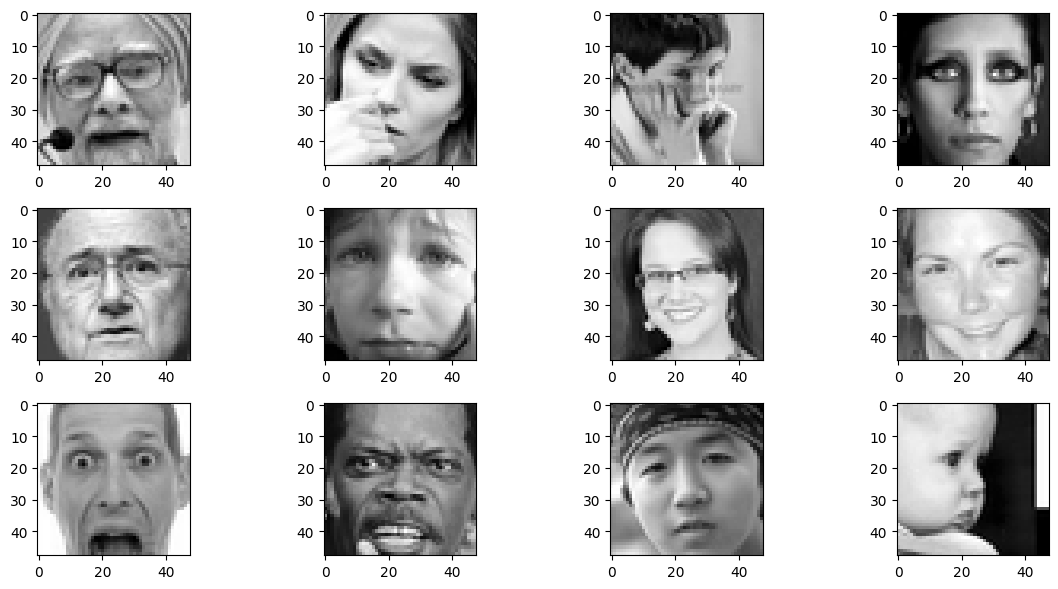

In [84]:
# Plotting some sample images from the training dataset
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(train_pixels[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

Data Augmentation

In [85]:
# Setting up data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_pixels)

Building the CNN Model

In [86]:
# Initializing a sequential model
model_1 = models.Sequential()

# Adding convolutional, pooling, and batch normalization layers
model_1.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model_1.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dense(7, activation='softmax'))

# Displaying the model summary
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 44, 44, 64)        1664      
                                                                 
 batch_normalization_7 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 18, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 18, 18, 64)       256       
 hNormalization)                                                 
                                                      

Compiling the Model

In [87]:
# Compiling the model with Adam optimizer and categorical crossentropy loss
model_1.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

Adding Callbacks

In [88]:
# Learning rate scheduler function
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch > 15:
        return initial_lr * 0.1
    elif epoch > 10:
        return initial_lr * 0.5
    return initial_lr

# Defining callbacks
lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('model/andres_best_model.keras', monitor='val_loss', save_best_only=True)


Training the Model

In [89]:
# Training the model with data augmentation and callbacks
history = model_1.fit(datagen.flow(train_pixels, train_labels, batch_size=256), 
                      epochs=50, 
                      validation_data=(private_pixels, private_labels), 
                      callbacks=[lr_scheduler, early_stopping, model_checkpoint])

Epoch 1/50
113/113 [==============================] - 5s 37ms/step - loss: 11.4253 - accuracy: 0.2773 - val_loss: 6.1957 - val_accuracy: 0.1655 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - 4s 36ms/step - loss: 4.0941 - accuracy: 0.3999 - val_loss: 3.1820 - val_accuracy: 0.1655 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - 4s 35ms/step - loss: 2.4376 - accuracy: 0.4357 - val_loss: 2.4744 - val_accuracy: 0.1655 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - 4s 35ms/step - loss: 1.9683 - accuracy: 0.4624 - val_loss: 2.1707 - val_accuracy: 0.3174 - lr: 0.0010
Epoch 5/50
113/113 [==============================] - 4s 35ms/step - loss: 1.8948 - accuracy: 0.4654 - val_loss: 2.2989 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 6/50
113/113 [==============================] - 4s 35ms/step - loss: 1.8460 - accuracy: 0.4820 - val_loss: 2.0047 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 7/50
113/113 [==============================] - 4s 36ms/s

Plotting Training and Validation Metrics

In [90]:
# Converting the history object to a pandas DataFrame
hist = pd.DataFrame(history.history)

# Plotting training and validation accuracy
fig = px.line(data_frame=hist, y=["accuracy", "val_accuracy"], markers=True)
fig.update_xaxes(title="Number of Epochs")
fig.update_yaxes(title="Accuracy")
fig.update_layout(showlegend=True, title={'text': 'Accuracy vs Number of Epochs', 'y': 0.94, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

# Plotting training and validation loss
fig = px.line(data_frame=hist, y=["loss", "val_loss"], markers=True)
fig.update_xaxes(title="Number of Epochs")
fig.update_yaxes(title="Loss")
fig.update_layout(showlegend=True, title={'text': 'Loss vs Number of Epochs', 'y': 0.94, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

Evaluating the Model

113/113 [==============================] - 0s 1ms/step


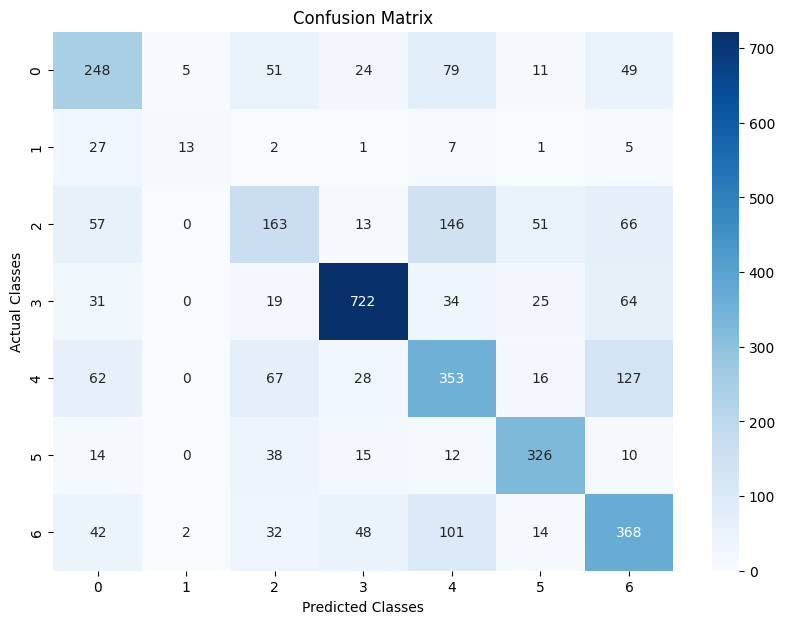

              precision    recall  f1-score   support

           0       0.52      0.53      0.52       467
           1       0.65      0.23      0.34        56
           2       0.44      0.33      0.38       496
           3       0.85      0.81      0.83       895
           4       0.48      0.54      0.51       653
           5       0.73      0.79      0.76       415
           6       0.53      0.61      0.57       607

    accuracy                           0.61      3589
   macro avg       0.60      0.55      0.56      3589
weighted avg       0.61      0.61      0.61      3589



In [91]:
# Predicting probabilities for the public test set
predictions_prob = model_1.predict(public_pixels)

# Converting probabilities to class indices
predictions = np.argmax(predictions_prob, axis=1)

# Converting one-hot encoded labels to class indices
true_labels = np.argmax(public_labels, axis=1)

# Computing the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5, 6], yticklabels=[0, 1, 2, 3, 4, 5, 6])
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

# Printing the classification report
print(classification_report(true_labels, predictions))

Making Predictions

In [92]:
# Predicting a single instance from the public test set
instance = public_pixels[0]
instance = np.expand_dims(instance, axis=0)
prediction = model_1.predict(instance)

# Displaying the prediction
print("Prediction (probability distribution over classes):", prediction)
predicted_class = np.argmax(prediction, axis=1)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 11ms/step
Prediction (probability distribution over classes): [[0.28569567 0.00647463 0.23843642 0.01831992 0.33307132 0.00787895
  0.11012313]]
Predicted class: [4]


Saving the Model

In [93]:
# Saving the model to a file
model_1.save('model/andres_model.keras')

In [94]:
# Function to process a new image for prediction
def process_image(image_path):
    # Load the image with target size of 48x48
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Normalize the image array
    img_array /= 255.0
    
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array